In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

images = np.load("/content/drive/MyDrive/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/content/drive/MyDrive/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/content/drive/MyDrive/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)


In [3]:
data = np.column_stack((images, masks, labels))
data.shape

(3064, 3)

In [4]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.08, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.12, random_state=42)

print("Train:", train_data.shape,
      "\nVal:", val_data.shape,
      "\nTest:", test_data.shape,)

Train: (2479, 3) 
Val: (246, 3) 
Test: (339, 3)


In [5]:
import cv2

def data_to_viz(data, label, n=5):

    # logical slice for receiving data with the expected label
    expected_index = np.where(data[:,2] == label)
    expected_data = data[expected_index]

    # n random samples
    index = np.random.choice(expected_data.shape[0], n, replace=False)
    data_to_viz = expected_data[index]

    imgs = []
    masks = []
    labels = []
    for data_i in data_to_viz:

        # img
        imgs.append(cv2.resize(data_i[0], (512, 512)))

        # mask
        masks.append(cv2.resize(data_i[1].astype("uint8"),
                                (512, 512)))

        # label
        labels.append(data_i[2])

    return np.hstack(imgs), np.hstack(masks), labels

In [6]:
meningiomas_imgs, meningiomas_masks, meningiomas_labels = data_to_viz(data, label=1, n=5)
glioma_imgs, glioma_masks, glioma_labels  = data_to_viz(data, label=2, n=5)
tumor_imgs, tumor_masks, tumor_labels = data_to_viz(data, label=3, n=5)

print("Meningiomas:",
      meningiomas_imgs.shape, meningiomas_masks.shape, meningiomas_labels)
print("Glioma:",
      glioma_imgs.shape, glioma_masks.shape, glioma_labels)
print("Pituitary Tumor:",
      tumor_imgs.shape, tumor_masks.shape, tumor_labels)

Meningiomas: (512, 2560) (512, 2560) [1, 1, 1, 1, 1]
Glioma: (512, 2560) (512, 2560) [2, 2, 2, 2, 2]
Pituitary Tumor: (512, 2560) (512, 2560) [3, 3, 3, 3, 3]


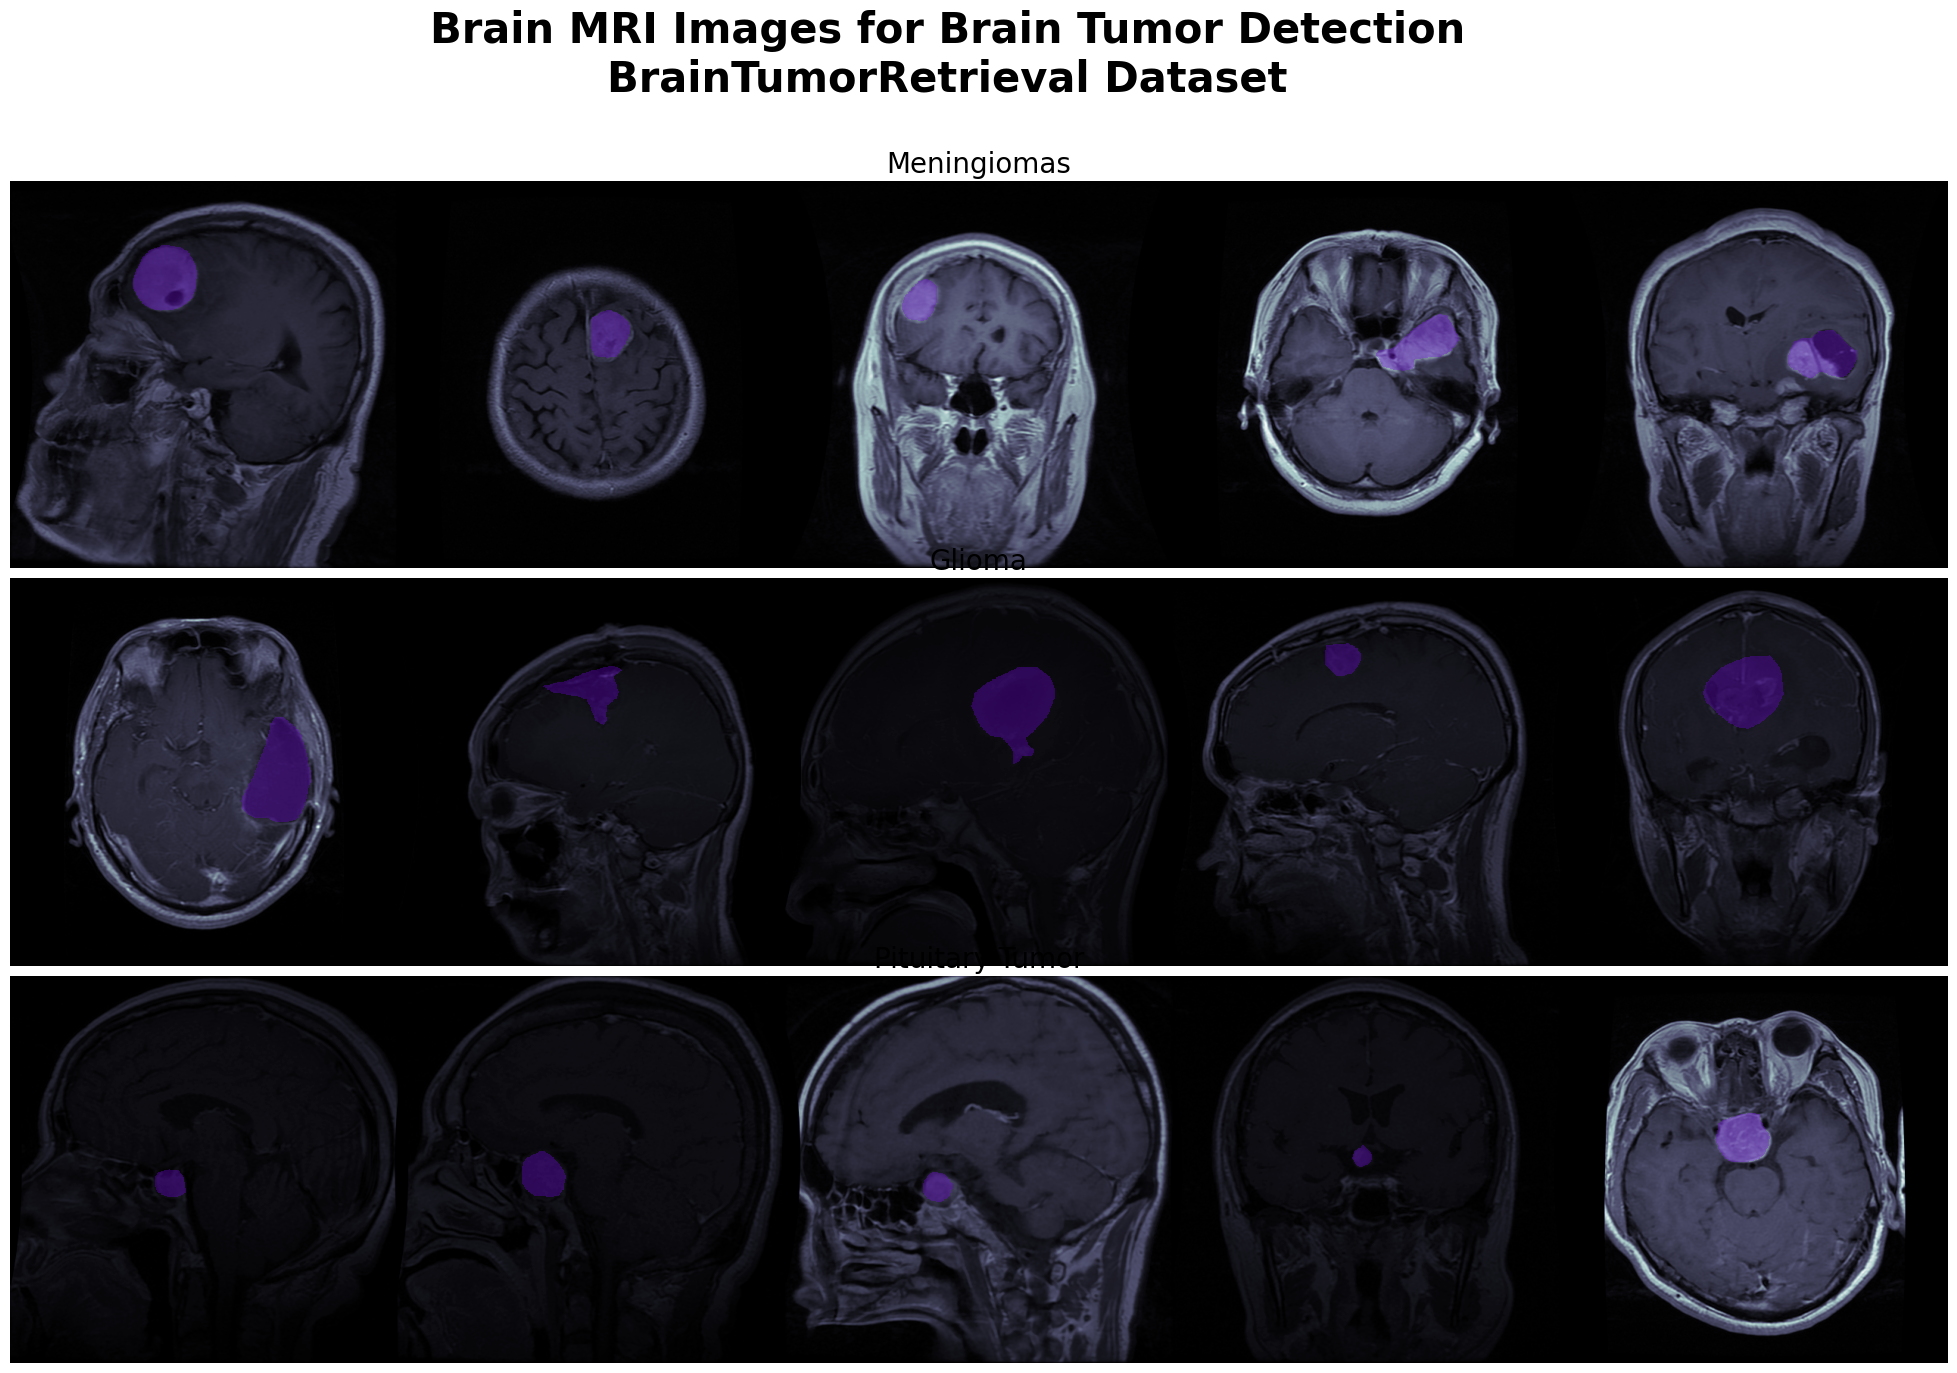

In [7]:
import matplotlib.pyplot as plt
# Data to visualization
from mpl_toolkits.axes_grid1 import ImageGrid

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 1),  # creates 1x4 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(meningiomas_imgs, cmap="bone")
grid[0].imshow(np.ma.masked_where(meningiomas_masks == False,
                                  meningiomas_masks), cmap='rainbow', alpha=0.3)

grid[0].set_title("Meningiomas", fontsize=20)
grid[0].axis("off")

grid[1].imshow(glioma_imgs, cmap="bone")
grid[1].imshow(np.ma.masked_where(glioma_masks == False,
                                  glioma_masks), cmap='rainbow', alpha=0.3)
grid[1].set_title("Glioma", fontsize=20)
grid[1].axis("off")

grid[2].imshow(tumor_imgs, cmap="bone")
grid[2].imshow(np.ma.masked_where(tumor_masks == False,
                                  tumor_masks), cmap='rainbow', alpha=0.3)

grid[2].set_title("Pituitary Tumor", fontsize=20)
grid[2].axis("off")


# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nBrainTumorRetrieval Dataset",
             y=.80, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", pad_inches=0.2, transparent=True)
plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
class BrainMriDataset(Dataset):
    def __init__(self, data, transforms, n_classes=3):

        self.data = data
        self.transforms = transforms
        self.n_classes = n_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image = self.data[idx][0].astype("float32")

        # global standardization of pixels
        mean, std = image.mean(), image.std()
        image = (image - mean) / std

        # convert to rgb
        image_rgb = np.stack([image]*3).transpose(1,2,0)

        # create target masks
        label = self.data[idx][2] -1
        mask = np.expand_dims(self.data[idx][1], -1)

        target_mask = np.zeros((mask.shape[0], mask.shape[1],
                                self.n_classes))
        target_mask[:,:, label : label + 1] = mask.astype("uint8")

        #  binary mask
        target_mask = np.clip(target_mask, 0, 1).astype("float32")

        # augmentations
        augmented = self.transforms(image=image_rgb,
                                    mask=target_mask)
        image = augmented['image']
        mask = augmented['mask']

        return image, mask

In [10]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5,
                       border_mode=0),

    A.GridDistortion(p=0.5),
    A.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
    A.Resize(156, 156, p=1.),
    A.RandomCrop(128, 128, p=1.)
    ])

In [11]:
# train
train_dataset = BrainMriDataset(data=train_data, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4,
                              shuffle=True)

# validation
val_dataset = BrainMriDataset(data=val_data, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4,
                            shuffle=True)

# test
test_dataset = BrainMriDataset(data=test_data, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=4,
                             shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([16, 128, 128, 3]) torch.Size([16, 128, 128, 3])


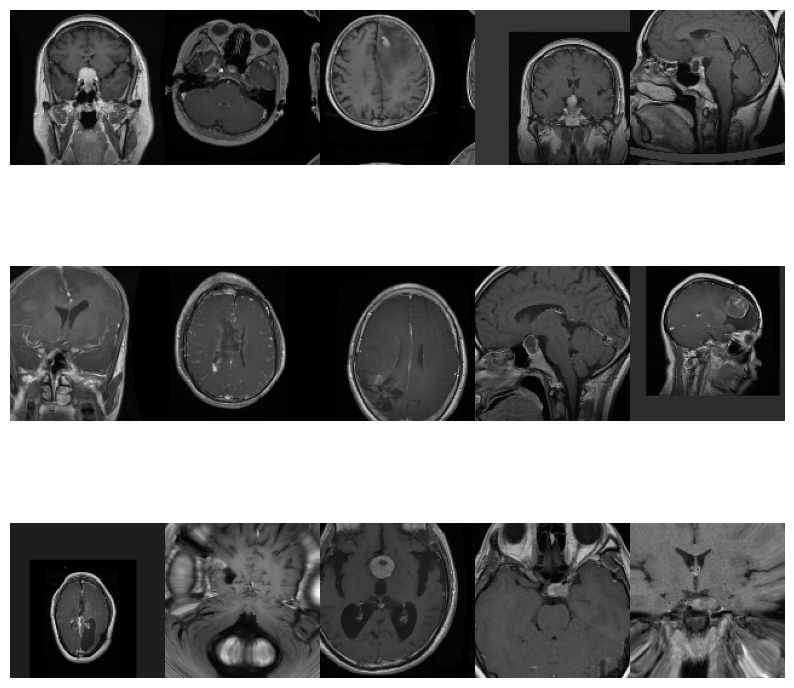

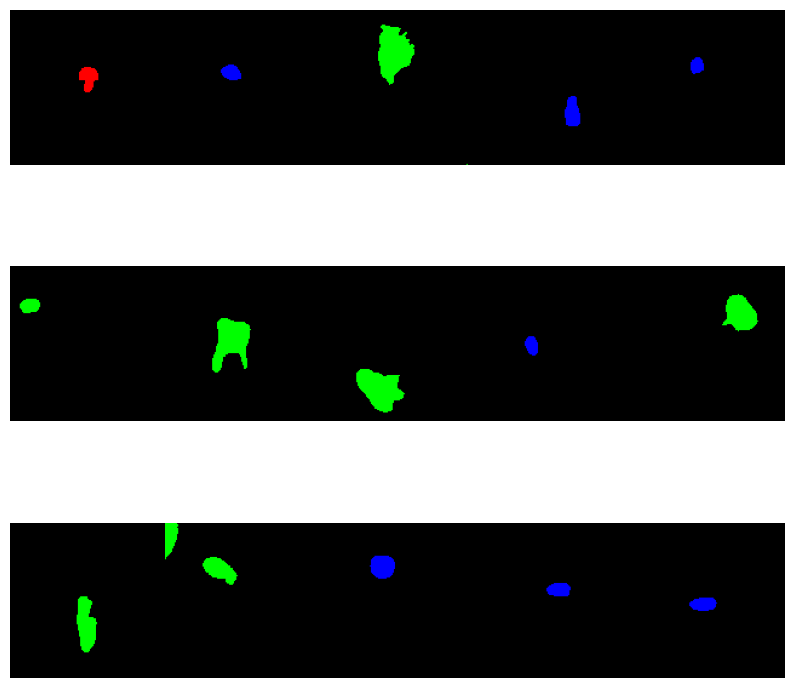

In [12]:
def show_aug(inputs, nrows=3, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0

    if len(inputs) > 15:
        inputs = inputs[:15]

    for idx in range(len(inputs)):

        # normalization
        if image is True:
            img = inputs[idx].numpy()#.transpose(1,2,0)
            img = (img - img.min()) / (img.max() - img.min())  # normalize to [0, 1]
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]

        #plot
        #print(img.max(), len(np.unique(img)), img.mean())
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img);
        plt.axis('off')

        i_ += 1

    return plt.show()

images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks)


In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, Add

def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def down_block(inputs, filters, pool_size=(2, 2)):
    x = conv_block(inputs, filters)
    pool = MaxPooling2D(pool_size)(x)
    return x, pool

def up_block(inputs, skip, filters, up_size=(2, 2)):
    x = UpSampling2D(up_size)(inputs)
    x = concatenate([x, skip], axis=3)
    x = conv_block(x, filters)
    return x

def laddernet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1, p1 = down_block(inputs, 16)
    c2, p2 = down_block(p1, 32)
    c3, p3 = down_block(p2, 64)
    c4, _ = down_block(p3, 128)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3], axis=3)
    c5 = conv_block(u5, 64)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2], axis=3)
    c6 = conv_block(u6, 32)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1], axis=3)
    c7 = conv_block(u7, 16)

    # Final Classifier
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

model = laddernet_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0

In [21]:
## Instantiate the LadderNet model
model = VNet(n_classes=3).to(device)

# Define the optimizer
adam = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=10, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_coef_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [24]:
def train_one_epoch(model, optimizer, lr_scheduler, data_loader, epoch):
    print("Start Train ...")
    model.train()

    losses = []
    accur = []

    for data, target in data_loader:

        data = data.permute(0,3,1,2).to(device)
        targets = target.permute(0,3,1,2).to(device)

        outputs = model(data)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        train_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())

        loss = bce_dice_loss(outputs, targets)

        losses.append(loss.item())
        accur.append(train_dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if lr_scheduler is not None:
        lr_scheduler.step()

    print("Epoch [%d]" % (epoch))
    print("Mean loss on train:", np.array(losses).mean(), "Mean DICE on train:", np.array(accur).mean())

    return np.array(losses).mean(), np.array(accur).mean()

In [23]:
def val_epoch(model, data_loader_valid, epoch, threshold=0.3):
    if epoch is None:
        print("Test Start...")
    else:
        print("Start Validation ...")

    model.eval()
    val_acc = []

    with torch.no_grad():
        for data, targets in data_loader_valid:

            data = data.permute(0,3,1,2).to(device)
            targets = targets.permute(0,3,1,2).to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            val_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())
            val_acc.append(val_dice)

        print("Epoch:  " + str(epoch) + "  Threshold:  " + str(threshold)\
              + " Mean Validation DICE Score:", np.array(val_acc).mean())

        return np.array(val_acc).mean()

In [25]:
from tqdm import trange
import os
import glob

weights_dir = "weights"
if os.path.exists(weights_dir) == False:
    os.mkdir(weights_dir)

num_epochs = 30
loss_history = []
train_dice_history = []
val_dice_history = []

for epoch in trange(num_epochs):
    loss, train_dice = train_one_epoch(model, adam, scheduler,
                                       train_dataloader, epoch)

    val_dice = valscore = val_epoch(model, val_dataloader, epoch)

    # train history
    loss_history.append(loss)
    train_dice_history.append(train_dice)
    val_dice_history.append(val_dice)

    # save best weights
    best_dice = max(val_dice_history)
    if val_dice >= best_dice:
        torch.save({'state_dict': model.state_dict()},
                   os.path.join(weights_dir, f"{val_dice:0.5f}_.pth"))

  0%|          | 0/30 [00:00<?, ?it/s]

Start Train ...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [0]
Mean loss on train: 0.8916036609680422 Mean DICE on train: 0.17608473526478766
Start Validation ...
Epoch:  0  Threshold:  0.3 Mean Validation DICE Score: 0.33480900002886477


  3%|▎         | 1/30 [01:45<50:53, 105.29s/it]

Start Train ...
Epoch [1]
Mean loss on train: 0.6619619429111481 Mean DICE on train: 0.4254374439369212
Start Validation ...
Epoch:  1  Threshold:  0.3 Mean Validation DICE Score: 0.4744269878115946


  7%|▋         | 2/30 [03:28<48:30, 103.93s/it]

Start Train ...
Epoch [2]
Mean loss on train: 0.5650061655429102 Mean DICE on train: 0.5066381668298301
Start Validation ...
Epoch:  2  Threshold:  0.3 Mean Validation DICE Score: 0.5275561535246709


 10%|█         | 3/30 [05:11<46:32, 103.42s/it]

Start Train ...
Epoch [3]
Mean loss on train: 0.5196325665520084 Mean DICE on train: 0.5362866605817671
Start Validation ...
Epoch:  3  Threshold:  0.3 Mean Validation DICE Score: 0.5302858886653804


 13%|█▎        | 4/30 [06:54<44:45, 103.29s/it]

Start Train ...
Epoch [4]
Mean loss on train: 0.48291589175501176 Mean DICE on train: 0.56595108958914
Start Validation ...
Epoch:  4  Threshold:  0.3 Mean Validation DICE Score: 0.5588075528787702


 17%|█▋        | 5/30 [08:36<42:51, 102.87s/it]

Start Train ...
Epoch [5]
Mean loss on train: 0.456494955478176 Mean DICE on train: 0.5943909890449043
Start Validation ...


 20%|██        | 6/30 [10:20<41:23, 103.47s/it]

Epoch:  5  Threshold:  0.3 Mean Validation DICE Score: 0.5347560614830592
Start Train ...
Epoch [6]
Mean loss on train: 0.4460939565973897 Mean DICE on train: 0.6022056033859365
Start Validation ...
Epoch:  6  Threshold:  0.3 Mean Validation DICE Score: 0.5654897797455266


 23%|██▎       | 7/30 [12:09<40:21, 105.28s/it]

Start Train ...
Epoch [7]
Mean loss on train: 0.4115934397905104 Mean DICE on train: 0.6232379110405578
Start Validation ...


 27%|██▋       | 8/30 [13:58<38:56, 106.21s/it]

Epoch:  7  Threshold:  0.3 Mean Validation DICE Score: 0.5316403141669754
Start Train ...
Epoch [8]
Mean loss on train: 0.4154062133642935 Mean DICE on train: 0.622393721095955
Start Validation ...
Epoch:  8  Threshold:  0.3 Mean Validation DICE Score: 0.6045827636888113


 30%|███       | 9/30 [15:45<37:17, 106.55s/it]

Start Train ...
Epoch [9]
Mean loss on train: 0.40743358779338096 Mean DICE on train: 0.6363440435305792
Start Validation ...


 33%|███▎      | 10/30 [17:27<35:02, 105.12s/it]

Epoch:  9  Threshold:  0.3 Mean Validation DICE Score: 0.5765219249141242
Start Train ...
Epoch [10]
Mean loss on train: 0.3622592597238479 Mean DICE on train: 0.6679299359577708
Start Validation ...
Epoch:  10  Threshold:  0.3 Mean Validation DICE Score: 0.6977035221925422


 37%|███▋      | 11/30 [19:09<33:01, 104.28s/it]

Start Train ...
Epoch [11]
Mean loss on train: 0.33221469771477485 Mean DICE on train: 0.7005548367414933
Start Validation ...


 40%|████      | 12/30 [20:50<30:58, 103.24s/it]

Epoch:  11  Threshold:  0.3 Mean Validation DICE Score: 0.6787200748949163
Start Train ...
Epoch [12]
Mean loss on train: 0.32318474525405516 Mean DICE on train: 0.7114500170739249
Start Validation ...


 43%|████▎     | 13/30 [22:33<29:11, 103.05s/it]

Epoch:  12  Threshold:  0.3 Mean Validation DICE Score: 0.6863109585908341
Start Train ...
Epoch [13]
Mean loss on train: 0.3203039159697871 Mean DICE on train: 0.7093159640240921
Start Validation ...


 47%|████▋     | 14/30 [24:17<27:34, 103.38s/it]

Epoch:  13  Threshold:  0.3 Mean Validation DICE Score: 0.6756226486387373
Start Train ...
Epoch [14]
Mean loss on train: 0.3164890148947316 Mean DICE on train: 0.7114221801757645
Start Validation ...
Epoch:  14  Threshold:  0.3 Mean Validation DICE Score: 0.6996833051703386


 50%|█████     | 15/30 [26:00<25:47, 103.18s/it]

Start Train ...
Epoch [15]
Mean loss on train: 0.31069035183998844 Mean DICE on train: 0.7177937817560371
Start Validation ...


 53%|█████▎    | 16/30 [27:42<24:01, 103.00s/it]

Epoch:  15  Threshold:  0.3 Mean Validation DICE Score: 0.6907945790158797
Start Train ...
Epoch [16]
Mean loss on train: 0.3094294148106729 Mean DICE on train: 0.7178958841883541
Start Validation ...
Epoch:  16  Threshold:  0.3 Mean Validation DICE Score: 0.7104834332502992


 57%|█████▋    | 17/30 [29:26<22:22, 103.28s/it]

Start Train ...
Epoch [17]
Mean loss on train: 0.30024884987261985 Mean DICE on train: 0.7230376501855668
Start Validation ...
Epoch:  17  Threshold:  0.3 Mean Validation DICE Score: 0.728825811070839


 60%|██████    | 18/30 [31:10<20:40, 103.37s/it]

Start Train ...
Epoch [18]
Mean loss on train: 0.2977529089297018 Mean DICE on train: 0.7249288118158208
Start Validation ...


 63%|██████▎   | 19/30 [32:53<18:56, 103.34s/it]

Epoch:  18  Threshold:  0.3 Mean Validation DICE Score: 0.706275419501284
Start Train ...
Epoch [19]
Mean loss on train: 0.2931824014071495 Mean DICE on train: 0.7297197119852648
Start Validation ...


 67%|██████▋   | 20/30 [34:34<17:07, 102.77s/it]

Epoch:  19  Threshold:  0.3 Mean Validation DICE Score: 0.7039200033944203
Start Train ...
Epoch [20]
Mean loss on train: 0.28710793756669567 Mean DICE on train: 0.7431059609346216
Start Validation ...


 70%|███████   | 21/30 [36:16<15:21, 102.34s/it]

Epoch:  20  Threshold:  0.3 Mean Validation DICE Score: 0.7035718931436215
Start Train ...
Epoch [21]
Mean loss on train: 0.286756123554322 Mean DICE on train: 0.7389577223789153
Start Validation ...


 73%|███████▎  | 22/30 [38:00<13:43, 102.94s/it]

Epoch:  21  Threshold:  0.3 Mean Validation DICE Score: 0.7132605280421979
Start Train ...
Epoch [22]
Mean loss on train: 0.2844500086961254 Mean DICE on train: 0.7415658475495371
Start Validation ...
Epoch:  22  Threshold:  0.3 Mean Validation DICE Score: 0.7306981314645002


 77%|███████▋  | 23/30 [39:42<11:59, 102.78s/it]

Start Train ...
Epoch [23]
Mean loss on train: 0.2825755019341746 Mean DICE on train: 0.7397603157447719
Start Validation ...


 80%|████████  | 24/30 [41:25<10:15, 102.62s/it]

Epoch:  23  Threshold:  0.3 Mean Validation DICE Score: 0.6924795288190264
Start Train ...
Epoch [24]
Mean loss on train: 0.2903987249059062 Mean DICE on train: 0.7406055601326798
Start Validation ...


 83%|████████▎ | 25/30 [43:08<08:34, 102.81s/it]

Epoch:  24  Threshold:  0.3 Mean Validation DICE Score: 0.729439814958705
Start Train ...
Epoch [25]
Mean loss on train: 0.2790807201016334 Mean DICE on train: 0.7485529477538714
Start Validation ...


 87%|████████▋ | 26/30 [44:51<06:51, 102.77s/it]

Epoch:  25  Threshold:  0.3 Mean Validation DICE Score: 0.7164037167854642
Start Train ...
Epoch [26]
Mean loss on train: 0.27936412110444037 Mean DICE on train: 0.7465008797945896
Start Validation ...


 90%|█████████ | 27/30 [46:36<05:10, 103.54s/it]

Epoch:  26  Threshold:  0.3 Mean Validation DICE Score: 0.7127156770864478
Start Train ...
Epoch [27]
Mean loss on train: 0.2847736130318334 Mean DICE on train: 0.7437743628135765
Start Validation ...


 93%|█████████▎| 28/30 [48:22<03:28, 104.39s/it]

Epoch:  27  Threshold:  0.3 Mean Validation DICE Score: 0.720145094310208
Start Train ...
Epoch [28]
Mean loss on train: 0.27766506575768996 Mean DICE on train: 0.7469864326996973
Start Validation ...


 97%|█████████▋| 29/30 [50:04<01:43, 103.49s/it]

Epoch:  28  Threshold:  0.3 Mean Validation DICE Score: 0.727767735617283
Start Train ...
Epoch [29]
Mean loss on train: 0.2905227965885593 Mean DICE on train: 0.7330703774134131
Start Validation ...


100%|██████████| 30/30 [51:47<00:00, 103.59s/it]

Epoch:  29  Threshold:  0.3 Mean Validation DICE Score: 0.7066048957099094


In [26]:
def plot_model_history(train_history,
                       val_history,
                       loss_history ,
                       num_epochs):

    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")
    plt.plot(x, loss_history, label='dice + bce', lw=3)

    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)
    plt.legend()

    return plt.show()


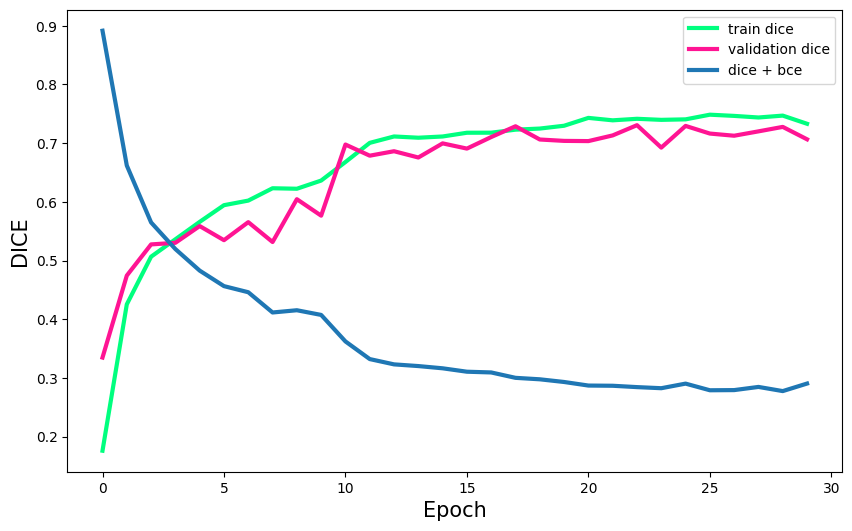

In [27]:
 plot_model_history(train_dice_history, val_dice_history, loss_history, num_epochs)

In [28]:
test_iou = val_epoch(model, test_dataloader, epoch=None, threshold=0.5)
print(f"""Mean IoU of the test images - {np.around(test_iou, 2)*100}%""")


Test Start...
Epoch:  None  Threshold:  0.5 Mean Validation DICE Score: 0.7478780120221052
Mean IoU of the test images - 75.0%


In [29]:
dices = []
thresholds = [0.1, 0.2, 0.33, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.88]
for i in thresholds:
    test_dice = val_epoch(model, test_dataloader,threshold=i, epoch=None)
    dices.append(test_dice)

Test Start...
Epoch:  None  Threshold:  0.1 Mean Validation DICE Score: 0.7242540810834605
Test Start...
Epoch:  None  Threshold:  0.2 Mean Validation DICE Score: 0.7278980629539556
Test Start...
Epoch:  None  Threshold:  0.33 Mean Validation DICE Score: 0.7074515625044495
Test Start...
Epoch:  None  Threshold:  0.4 Mean Validation DICE Score: 0.7363289098824758
Test Start...
Epoch:  None  Threshold:  0.5 Mean Validation DICE Score: 0.7311200654837736
Test Start...
Epoch:  None  Threshold:  0.6 Mean Validation DICE Score: 0.7277415711711676
Test Start...
Epoch:  None  Threshold:  0.7 Mean Validation DICE Score: 0.7461701019527939
Test Start...
Epoch:  None  Threshold:  0.8 Mean Validation DICE Score: 0.7180441942226198
Test Start...
Epoch:  None  Threshold:  0.85 Mean Validation DICE Score: 0.7357542164378451
Test Start...
Epoch:  None  Threshold:  0.88 Mean Validation DICE Score: 0.7268825400426023


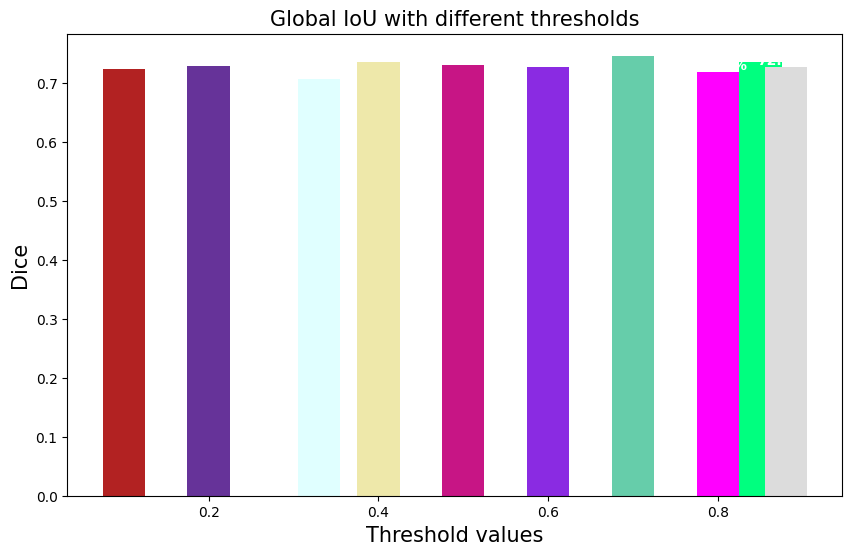

In [30]:
import random
import matplotlib.colors as mcolors

colors = random.choices(list(mcolors.CSS4_COLORS.keys()),k=len(thresholds))

plt.figure(figsize=(10,6))
plt.bar(thresholds, dices, width=0.05, color=colors)
plt.ylabel("Dice", fontsize=15)
plt.xlabel("Threshold values", fontsize=15)
plt.title("Global IoU with different thresholds", fontsize=15)


# Annotate
for row, value in zip(thresholds, dices):
    plt.annotate(f"{value*100:0.2f}%", xy=(row, value),
                 rotation=0, color="white",
                 ha="center", verticalalignment='bottom',
                 fontsize=10, fontweight="bold")


In [31]:
test_predictions = []
test_ground_truths = []
for data, target in test_dataloader:
    with torch.no_grad():
        data = data.permute(0,3,1,2).to(device)
        target = target.permute(0,3,1,2)
        prediction = model(data)
        test_predictions.append(prediction.detach().cpu())
        test_ground_truths.append(target)

In [32]:
test_predictions = torch.cat(test_predictions)
test_ground_truths = torch.cat(test_ground_truths)
#test_predictions = test_predictions.reshape(test_predictions.shape[0], -1)
#test_ground_truths = test_ground_truths.reshape(test_ground_truths.shape[0], -1)

print(test_predictions.shape, test_ground_truths.shape)

torch.Size([339, 3, 128, 128]) torch.Size([339, 3, 128, 128])


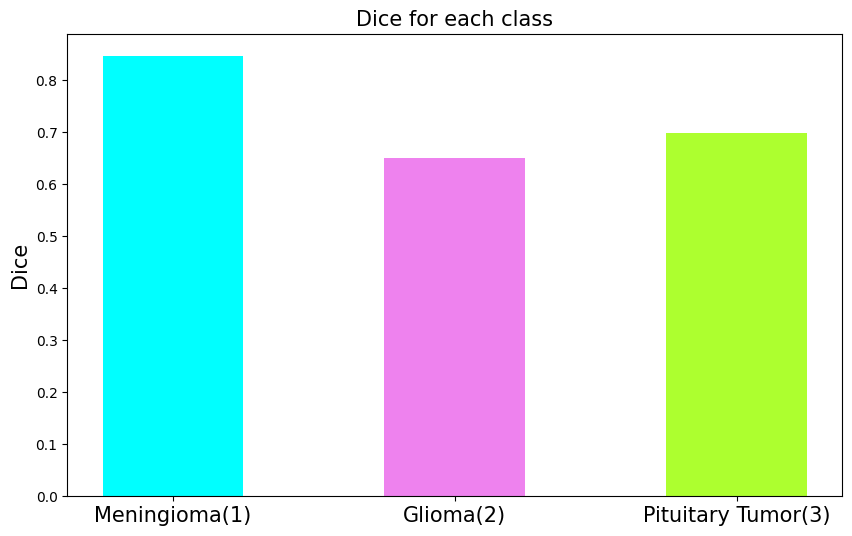

In [33]:
#data
dice1 = dice_coef_metric(test_predictions[:,0,:,:], test_ground_truths[:,0,:,:])
dice2 = dice_coef_metric(test_predictions[:,1,:,:], test_ground_truths[:,1,:,:])
dice3 = dice_coef_metric(test_predictions[:,2,:,:], test_ground_truths[:,2,:,:])
dices = [dice1, dice2, dice3]

# x, y
x = np.arange(3)
dices = [dice1, dice2, dice3]

# plot
plt.figure(figsize=(10, 6))
plt.bar(x, dices,
        color=["aqua", "violet", "greenyellow"], width=0.5)


plt.xticks(x, ['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'], fontsize=15)
plt.ylabel("Dice", fontsize=15)
plt.title("Dice for each class", fontsize=15)


# Annotate
for row, value in zip(x, dices):
    plt.annotate(f"{value*100:0.3f}%", xy=(row, value),
                 rotation=0, color="white",
                 ha="center", verticalalignment='bottom',
                 fontsize=10, fontweight="bold")

plt.show()

In [34]:
index = np.random.choice(test_data.shape[0], 1, replace=False)

# image
image = test_data[index][0][0]

# global standardization of pixels
mean, std = image.mean(), image.std()
image = (image - mean) / std
image = cv2.resize(image, (128, 128))
# convert to rgb
image = np.stack([image]*3).transpose(1,2,0)

# mask
mask = test_data[index][0][1]

# label
label = test_data[index][0][2]

print(image.shape, mask.shape, label)


(128, 128, 3) (512, 512) 3


Text(0.5, 1.0, 'Pituitary tumor')

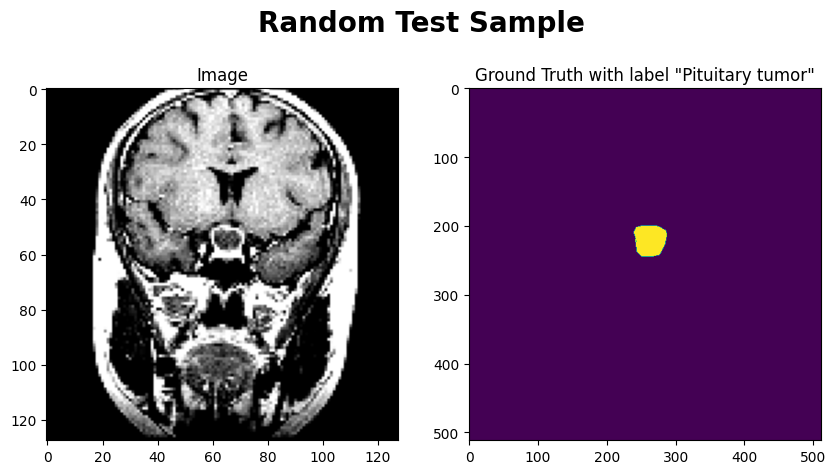

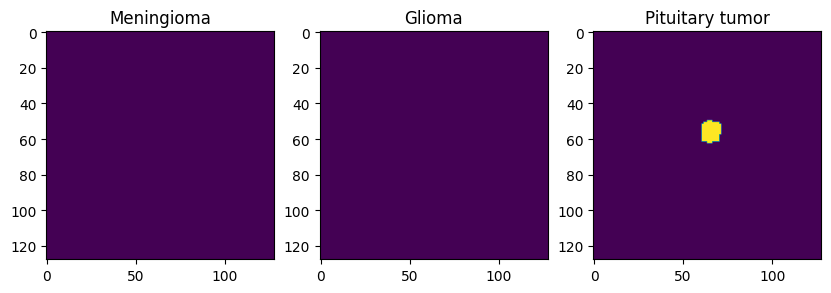

In [35]:
# predictions
preds = torch.tensor(image.astype(np.float32)).unsqueeze(0).permute(0,3,1,2)
preds = model(preds.to(device))
preds = preds.detach().cpu().numpy()

# threshold
preds[np.nonzero(preds < 0.4)] = 0.0
preds[np.nonzero(preds >= 0.4)] = 255.#1.0
preds = preds.astype("uint8")

pred_1 = preds[:,0,:,:]
pred_2 = preds[:,1,:,:]
pred_3 = preds[:,2,:,:]


#------------ Plot ------------#

# data plot
fig, ax = plt.subplots(nrows=1,  ncols=2, figsize=(10, 10))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title(f'Ground Truth with label "{integer_to_class[label].capitalize()}"')
#ax[1].imshow(preds[0,:,:,:])
#ax[0].set_title("Preiction")
plt.suptitle("Random Test Sample",
             y=.75, fontsize=20, weight="bold")

# prediction plot
fig, ax = plt.subplots(nrows=1,  ncols=3, figsize=(10, 10))

ax[0].imshow(pred_1[0,:,:])
ax[0].set_title(f'{integer_to_class[1].capitalize()}')
ax[1].imshow(pred_2[0,:,:])
ax[1].set_title(f'{integer_to_class[2].capitalize()}')
ax[2].imshow(pred_3[0,:,:])
ax[2].set_title(f'{integer_to_class[3].capitalize()}')

In [36]:
class VNet(nn.Module):
    def __init__(self, n_classes):
        super(LadderNet, self).__init__()

        # Base ResNeXt50 model
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]

        # Down (Encoder)
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up (Decoder)
        self.decoder4 = LadderDecoderBlock(filters[3], filters[2])
        self.decoder3 = LadderDecoderBlock(filters[2], filters[1])
        self.decoder2 = LadderDecoderBlock(filters[1], filters[0])
        self.decoder1 = LadderDecoderBlock(filters[0], filters[0])

        # Final Convolution
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)

    def forward(self, x):
        # Down (Encoder)
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up (Decoder) + Skip Connections
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Convolution
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)

        return out



In [37]:
model = VNet(n_classes=3).to(device)
adam = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=10, gamma=0.1)


NameError: name 'LadderNet' is not defined

In [ ]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_coef_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [ ]:
def train_one_epoch(model, optimizer, lr_scheduler, data_loader, epoch):
    print("Start Train ...")
    model.train()

    losses = []
    accur = []

    for data, target in data_loader:

        data = data.permute(0,3,1,2).to(device)
        targets = target.permute(0,3,1,2).to(device)

        outputs = model(data)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        train_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())

        loss = bce_dice_loss(outputs, targets)

        losses.append(loss.item())
        accur.append(train_dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if lr_scheduler is not None:
        lr_scheduler.step()

    print("Epoch [%d]" % (epoch))
    print("Mean loss on train:", np.array(losses).mean(), "Mean DICE on train:", np.array(accur).mean())

    return np.array(losses).mean(), np.array(accur).mean()

In [ ]:
def val_epoch(model, data_loader_valid, epoch, threshold=0.3):
    if epoch is None:
        print("Test Start...")
    else:
        print("Start Validation ...")

    model.eval()
    val_acc = []

    with torch.no_grad():
        for data, targets in data_loader_valid:

            data = data.permute(0,3,1,2).to(device)
            targets = targets.permute(0,3,1,2).to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            val_dice = dice_coef_metric(out_cut, targets.data.cpu().numpy())
            val_acc.append(val_dice)

        print("Epoch:  " + str(epoch) + "  Threshold:  " + str(threshold)\
              + " Mean Validation DICE Score:", np.array(val_acc).mean())

        return np.array(val_acc).mean()

In [ ]:
import os
import numpy as np
from PIL import Image

# Define input file path
input_file = "/content/drive/MyDrive/brain_tumor_dataset/images.npy"

# Define output directory
output_dir = "/content/drive/MyDrive/Dataset_jpg/images"
# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load .npy file
npy_data = np.load(input_file, allow_pickle=True)

# Iterate over each array in the .npy file
for i, data in enumerate(npy_data):
    # Convert to image
    image = Image.fromarray(data)

    # Convert image mode to 'RGB'
    image = image.convert('RGB')

    # Save the image in .jpg format
    image.save(os.path.join(output_dir, f"image_{i}.jpg"))

print("Conversion completed successfully.")


Conversion completed successfully.


In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the input image(s)
image_path = "/content/drive/MyDrive/Dataset_jpg/images/image_10.jpg"  # Replace with the path to your input image

# Define the path to the trained model
model_path = "/content/drive/MyDrive/trained_model.pth"  # Replace with the path to your trained model

# Define the model architecture
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = torch.nn.Linear(10, 5)

    def forward(self, x):
        return self.fc(x)

# Create an instance of the model
model = SimpleModel()

# Load the state dictionary of the trained model
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path)
    # Perform any necessary preprocessing such as resizing, normalization, etc.
    # Convert the image to a torch.FloatTensor and normalize it to [0, 1]
    image_tensor = torch.tensor(np.array(image), dtype=torch.float32) / 255.0
    return image_tensor

# Perform inference
def predict(model, image):
    # Convert the image to a PyTorch tensor
    image_tensor = torch.tensor(np.array(image)).unsqueeze(0)  # Add batch dimension
    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)
    # Perform any necessary post-processing of the output
    # For example, convert the output to a segmentation mask
    segmentation_mask = output.argmax(dim=1).squeeze().numpy()
    return segmentation_mask

# Predict segmentation mask for the input image
input_image = preprocess_image(image_path)
segmentation_mask = predict(model, input_image)

# Visualize the segmentation mask
plt.imshow(segmentation_mask, cmap='gray')
plt.axis('off')
plt.show()

# Save the segmentation mask
output_mask_path = "predicted_mask.jpg"
Image.fromarray(segmentation_mask.astype(np.uint8)).save(output_mask_path)
print(f"Segmentation mask saved as '{output_mask_path}'")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (262144x3 and 10x5)

In [ ]:
import torch
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the input image(s) in .npy format
image_npy_path = "/content/drive/MyDrive/brain_tumor_dataset/images.npy"  # Replace with the path to your input image in .npy format

# Define the path to the trained model
model_path = "/content/drive/MyDrive/trained_model.pth"  # Replace with the path to your trained model

# Define your model architecture
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = torch.nn.Linear(10, 5)

    def forward(self, x):
        return self.fc(x)

# Instantiate the model
model = SimpleModel()

# Load the trained model state_dict
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

# Preprocess the input image
def preprocess_image(image_array):
    # Perform any necessary preprocessing such as normalization
    # Convert the image array to the format expected by the model (e.g., PyTorch tensor)
    return torch.tensor(image_array).unsqueeze(0)  # Add batch dimension

# Perform inference
def predict(model, image_array):
    # Convert the image array to a PyTorch tensor
    image_tensor = preprocess_image(image_array)
    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)
    # Perform any necessary post-processing of the output
    # For example, convert the output to a segmentation mask
    segmentation_mask = output.argmax(dim=1).squeeze().numpy()
    return segmentation_mask

# Predict segmentation masks for images in the .npy folder
npy_folder = "/content/drive/MyDrive/brain_tumor_dataset"  # Replace with the path to your .npy folder
for filename in os.listdir(npy_folder):
    if filename.endswith(".npy"):
        # Load .npy file
        npy_data = np.load(os.path.join(npy_folder, filename), allow_pickle=True)

        # Preprocess the image
        input_image = preprocess_image(npy_data)

        # Predict segmentation mask
        segmentation_mask = predict(model, input_image)

        # Visualize the segmentation mask
        plt.imshow(segmentation_mask, cmap='gray')
        plt.axis('off')
        plt.show()


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Define the path to the input .npy folder
npy_folder = "/content/drive/MyDrive/brain_tumor_dataset/images.npy"
# Define the path to the trained model
model_path = "/content/drive/MyDrive/trained_model.pth"
# Define your model architecture
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Define your model architecture here

    def forward(self, x):
        # Define the forward pass of your model
        return x

# Create an instance of your model
model = YourModel()

# Load the trained weights into your model
model.load_state_dict(torch.load(model_path))
model.eval()

# Preprocess the input image
def preprocess_image(image_array):
    # Perform any necessary preprocessing such as normalization
    # Convert the image array to the format expected by the model (e.g., PyTorch tensor)
    return torch.tensor(image_array).unsqueeze(0)  # Add batch dimension

# Perform inference
def predict(model, image_array):
    # Convert the image array to a PyTorch tensor
    image_tensor = preprocess_image(image_array)
    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)
    # Perform any necessary post-processing of the output
    # For example, convert the output to a segmentation mask
    segmentation_mask = output.argmax(dim=1).squeeze().numpy()
    return segmentation_mask

# Predict segmentation masks for images in the .npy folder
for filename in os.listdir(npy_folder):
    if filename.endswith(".npy"):
        # Load .npy file
        npy_data = np.load(os.path.join(npy_folder, filename))

        # Preprocess the image
        input_image = preprocess_image(npy_data)

        # Predict segmentation mask
        segmentation_mask = predict(model, input_image)

        # Visualize the segmentation mask
        plt.imshow(segmentation_mask, cmap='gray')
        plt.axis('off')
        plt.show()


RuntimeError: Error(s) in loading state_dict for YourModel:
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 